<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/Demo%20Models/Colab%20Notebooks/GPTfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**coding the tokenizer first**

In [ ]:
# creating a sub-word level tokenizer
import re
from collections import defaultdict

class SubwordTokenizer:
    def __init__(self, num_merges):
        self.num_merges = num_merges
        self.vocab = None

    def get_stats(self, vocab):
        pairs = defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[symbols[i], symbols[i+1]] += freq
        return pairs

    def merge_vocab(self, pair, vocab):
        new_vocab = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        for word in vocab:
            new_word = word.replace(bigram, replacement)
            new_vocab[new_word] = vocab[word]
        return new_vocab

    def learn_bpe(self, data):
        vocab = defaultdict(int)
        for word in data:
            vocab[''.join(list(word)) + '</w>'] += 1

        for i in range(self.num_merges):
            pairs = self.get_stats(vocab)
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            vocab = self.merge_vocab(best_pair, vocab)

        self.vocab = vocab

    def tokenize_generator(self, text):
      if isinstance(text, list):
        for word in text:
            word = ' '.join(list(word))
            if word in self.vocab:
                yield word
            else:
                yield word[:2]  # yield the initial part of the word
                yield from (word[i:i+2] for i in range(2, len(word), 2) if word[i:i+2] in self.vocab)
      else:
        word = ' '.join(list(text))
        if word in self.vocab:
            yield word
        else:
            yield word[:2]  # yield the initial part of the word
            yield from (word[i:i+2] for i in range(2, len(word), 2) if word[i:i+2] in self.vocab)

    def tokenize(self, text):
      return list(self.tokenize_generator(text))

    def detokenize(self, tokens):
        detokenized_txt = ''.join(tokens)
        return detokenized_txt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# data for training the BPE
with open('/content/drive/MyDrive/training_data.txt', 'r', encoding='utf-8') as file:
  captions = file.read()

# tokenizing
import nltk
nltk.download('punkt')
token_caps = nltk.word_tokenize(captions)

In [ ]:
# train test split
n = int(0.8*len(token_caps))
bpe_train_data = token_caps[:n]
bpe_val_data = token_caps[n:]

In [ ]:
# training the tokenizer on the training data
num_merges = 50
tokenizer = SubwordTokenizer(num_merges)
tokenizer.learn_bpe(bpe_train_data)

In [ ]:
# tokenizing the data separately

# normal tokenization first
train_words = nltk.word_tokenize(train_data)
val_words = nltk.word_tokenize(val_data)

# sub-word tokenization in batches
batch_size = 100
trained_data = [tokenizer.tokenize(train_words[i:i+batch_size]) for i in range(0, len(train_words), batch_size)]
valed_data = [tokenizer.tokenize(val_words[i:i+batch_size]) for i in range(0, len(val_words), batch_size)]

In [ ]:
# flatten the batches
trained_data = [token for batch in trained_data for token in batch]
valed_data = [token for batch in valed_data for token in batch]

In [ ]:
print(train_data[:10])
print(tokenizer.detokenize(train_data[:10]))
print(val_data[:10])
print(tokenizer.detokenize(val_data[:10]))

**main gpt starts from here**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# importing the data
file_path = '/content/drive/MyDrive/new_training_data.txt'
with open(file_path, 'r', encoding='utf-8') as file:
  data = file.read()
total_no_of_words = len(data)
print(total_no_of_words)

219382798


In [4]:
# total no of chars and vocab size
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡£­°²³´µ·¼½ÀÁÃÄÅÉÍÓÖ×ßàáâãäåæçèéêëìíîïñòóôõöøúüāăćČĐğīİŁłōśūŻʖʻʼ̴̵̶̷̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̭̮̯̰̱̲̳̹̺̻̼͇͈͉͍͎͓͔͕͖͙͚̀́̂̃̄̅̆̇̈̉̊̋̌̍̎̏̐̑̒̓̔̽̾̿̀́͂̓̈́͆͊͋͌͐͑͒͗͛̕̚͘͜͝͠͡ͅΧιρςστχόϑДಠ ​‍–—―‘’‚“”… ›‽⁠₂€₹™⅓⅔∆−≈⍵♩♪♫♬♭⚡✨。えァアウェオサシジスッデトナニビフブボメョリルロンー一万写動千夜如宇宏开忽春来树梨活真花萌风꞉️﻿，ａｄｅｇｈｉｍｎｒｔｕｖｙ�𝅘𝅥𝅮𝔻𝕄𝕌𝕐𝕒𝕓𝕔𝕕𝕖𝕗𝕘𝕙𝕚𝕛𝕜𝕝𝕞𝕟𝕠𝕡𝕢𝕣𝕤𝕥𝕦𝕧𝕨𝕪𝘐𝘢𝘣𝘤𝘥𝘦𝘧𝘩𝘪𝘭𝘮𝘯𝘰𝘱𝘳𝘴𝘵𝘶𝘸𝘺🔮🤔
416


In [5]:
# train-test split

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [6]:
import timeit

start_time_2 = timeit.default_timer()

In [7]:
# encoder and decoder of the text
string_to_index = { ch:i for i,ch in enumerate(chars) }
index_to_string = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [string_to_index[c] for c in s]
decode = lambda l: ''.join([index_to_string[i] for i in l])

print(encode('hello there'))
print(decode(encode('hello there')))

[73, 70, 77, 77, 80, 1, 85, 73, 70, 83, 70]
hello there


In [8]:
import torch

# Convert to tensors
train_data = torch.tensor(encode(train_data), dtype=torch.long)
val_data = torch.tensor(encode(val_data), dtype=torch.long)

In [9]:
print(train_data[:20], len(train_data), len(val_data))

tensor([56, 73, 90,  1, 88, 70, 83, 70,  1, 85, 73, 70,  1, 88, 73, 70, 70, 77,
        84,  1]) 197444518 21938280


**main bigram transformer model**

In [10]:
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 128 # independent sequences in parallel
block_size = 256 # max context length for predictions
max_iters = 5000
eval_interval = 100 # after interval outputs
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 8
n_layer = 6
dropout = 0.3
# ------------

torch.manual_seed(1337)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store step and loss values for visualization
        steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
torch.save(model.state_dict(), 'large_parameter_transformer_model.pth')
output_data = decode(m.generate(context, max_new_tokens=2000)[0].tolist())
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

11.058848 M parameters
step 0: train loss 6.2578, val loss 6.2638
step 100: train loss 2.4326, val loss 2.5175
step 200: train loss 2.3537, val loss 2.4177
step 300: train loss 2.0659, val loss 2.1179
step 400: train loss 1.8053, val loss 1.8415
step 500: train loss 1.6527, val loss 1.6787
step 600: train loss 1.5503, val loss 1.5679
step 700: train loss 1.4810, val loss 1.4929
step 800: train loss 1.4324, val loss 1.4357
step 900: train loss 1.3903, val loss 1.4002
step 1000: train loss 1.3643, val loss 1.3790
step 1100: train loss 1.3337, val loss 1.3404
step 1200: train loss 1.3200, val loss 1.3248
step 1300: train loss 1.3002, val loss 1.3054
step 1400: train loss 1.2838, val loss 1.2884
step 1500: train loss 1.2679, val loss 1.2741
step 1600: train loss 1.2569, val loss 1.2589
step 1700: train loss 1.2389, val loss 1.2435
step 1800: train loss 1.2246, val loss 1.2317
step 1900: train loss 1.2206, val loss 1.2210
step 2000: train loss 1.2100, val loss 1.2164
step 2100: train loss 1

In [11]:
model_train = timeit.default_timer()

print(f"time taken to train the model {(model_train - start_time_2) / 3600 } hrs")

time taken to train the model 1.0235756409075 hrs


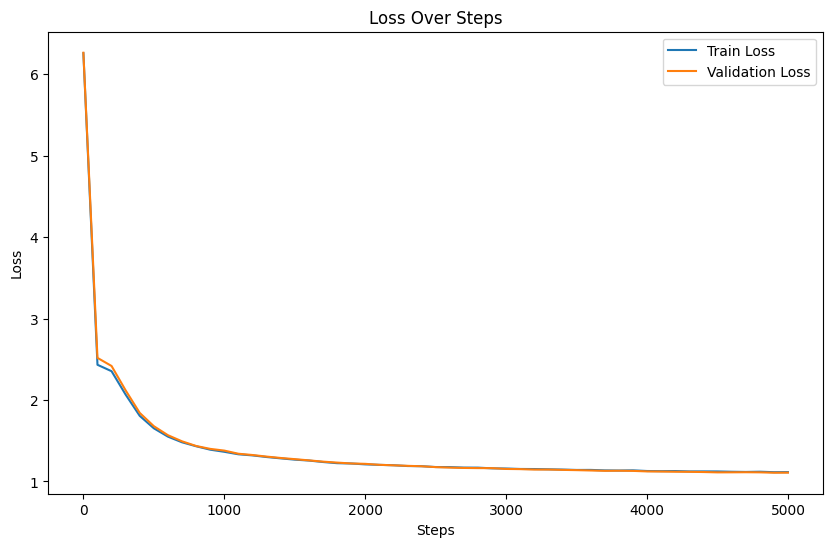

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# summary
end_time = timeit.default_timer()

total_time = (end_time - start_time_2) / 3600

ffn_factor = 4
embedding_params = n_embd * vocab_size
attention_params = n_head * (n_embd // n_head * 2 * n_embd) * n_layer

feedforward_params = n_embd * ffn_factor * n_layer * 2
total_param = sum(p.numel() for p in m.parameters()) / 1e6
total_params = embedding_params + attention_params + feedforward_params

print("///// summary /////")
# print(f"time just to fetch the data was {(data_coll - start_time) / 3600} hrs and no of videos fetched were {videoNo}")
print(f"total no of words in the file were: {total_no_of_words/1e6} million")
print(f"total vocab size was {vocab_size}")
print("total no of calculated parameters:", total_params)
print("total no of actual parameters:", total_param)
print(f"time taken to train the model was {(model_train - start_time_2) / 3600} hrs")
print(f"model ran for {max_iters} iterations and final val loss: {val_losses[-1]} and train loss: {train_losses[-1]}")
print('\n', '\n')
print("//// generated output ////")
print(output_data)

///// summary /////
total no of words in the file were: 219.382798 million
total vocab size was 416
total no of calculated parameters: 1947648
total no of actual parameters: 11.058848
time taken to train the model was 1.0235756409075 hrs
model ran for 5000 iterations and final val loss: 1.1082205772399902 and train loss: 1.114668369293213

 

//// generated output ////

in his energy browality Trop his crue she
is a 1-year-tempi energy Poster. Especially, posters she researching the animator of
the resitants, but a ‘earer for fordunately we she sounds the copies 
for comed this. the weddie showerfig
the cruewired second in instealed himself,
Ohio. There was I-special headiet. The company. "Constraine Twine ireleva. Both the shooths assistational his sonscientific increased users who will just
leave that allies bone. And these geod, who might receigned likelins
agreed to piece a repeat of friends
our next weark sets in Russian. SafeCial Warn
to be coming, and as many differences of
like

In [14]:
# Load the saved model
loaded_model = BigramLanguageModel()
loaded_model.load_state_dict(torch.load('large_parameter_transformer_model.pth'))
loaded_model.to(device)

# Print detailed information about the model's state dictionary
for name, param in loaded_model.named_parameters():
    print(f'{name}: {param.shape}, {param.numel()} parameters')

token_embedding_table.weight: torch.Size([416, 384]), 159744 parameters
position_embedding_table.weight: torch.Size([256, 384]), 98304 parameters
blocks.0.sa.heads.0.key.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.0.query.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.0.value.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.1.key.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.1.query.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.1.value.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.2.key.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.2.query.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.2.value.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.3.key.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.3.query.weight: torch.Size([48, 384]), 18432 parameters
blocks.0.sa.heads.3.value.weight: torch.Size([48